
# CheXpert : Defer experiments

This notebook produces the figures for a synthethic expert model described in the paper.

Note: this notebook requires the downsampled CheXpert dataset which can be obtained from: https://stanfordmlgroup.github.io/competitions/chexpert/

Credit: parts of this code were adapted from https://github.com/gaetandi/cheXpert




# Imports and Data Prep

We assume that CheXpert is available in the same directory, the path to each image file is in the .cvs files  under column Path: example "CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg", you will need to change the loader in CheXpertDataSet_rad if you have a different path for the image files.


In [ ]:
pathFileTrain = 'CheXpert-v1.0-small/train.csv' 
pathFileValid = 'CheXpert-v1.0-small/valid.csv'

Get CheXpert data and dataset of expert data on test set and models

In [ ]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import copy
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.ranking import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import random
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Expert model

Fake expert model:

If there is a supporting device, with probability p_nonconfound we are correct and if there is no support devices with probability p_confound we are correct.

In [ ]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
class ExpertModel_fake():
    def __init__(self, confounding_class, p_confound, p_nonconfound):
        self.confounding_class = confounding_class
        self.p_confound = p_confound
        self.p_nonconfound = p_nonconfound
    def predict(self, y):
        '''
        Using backoff
        y: list of targets where each is a python list of size 14
        returns: expert predictions for each of  expert 1
        '''
        preds = [[] for _ in range(3)]
        for rad_index in range(3):
            for i in range(len(y)):
                pred = [0] *14
                key_all = str(y[i])
                for cls in range(14):
                    if y[i][self.confounding_class] == 0:
                        if y[i][cls] == 1:
                            prediction = np.random.binomial(1,self.p_confound,1)[0]
                            pred[cls] = prediction
                        else:
                            prediction = np.random.binomial(1,1- self.p_confound,1)[0]
                            pred[cls] = prediction
                    else:
                        if y[i][cls] == 1:
                            prediction = np.random.binomial(1,self.p_nonconfound,1)[0]
                            pred[cls] = prediction
                        else:
                            prediction = np.random.binomial(1,1- self.p_nonconfound,1)[0]
                            pred[cls] = prediction       
                        #prediction = np.random.binomial(1,y[i][cls],1)[0]
                        #pred[cls] = prediction
                preds[rad_index].append(pred)
        return preds

In [ ]:
p_confound = 0.7 # fixed
p_nonconfound = 1.0
exp_fake = ExpertModel_fake(13,p_confound, p_nonconfound)

## Build Training and Valid set augmented with the expert predictions

A dataset that takes in an expert model to label all points, uncertain and blank labels are treated as either 1 or 0 (ones or zeros policy)

In [ ]:
class CheXpertDataSet_rad(Dataset):
    def __init__(self, image_list_file, expert_model, patient_names,  transform=None, ignore_uncertain = True, policy="ones"):
        """
        image_list_file: path to the file containing images with corresponding labels.
        expert_model: instance of ExpertModel_1 trained
        patient_names: which patients to include in set, dictionary
        is_val: if using the validation set 
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels: ones by default
        """
        image_names = []
        labels = []
        rad_1 = []
        rad_2 = []
        rad_3 = []
        weights = [] # indicates if uncertainty label is present or not for each task
        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1

                image_name= line[0]
                patient_name = line[0].split("/")[2]
                label = line[5:]
                weight = [1] *14
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1: # uncertain label
                            if ignore_uncertain:
                                weight[i] = 0
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                if patient_name in patient_names:
                    image_names.append( image_name)
                    labels.append(label)
                    weights.append(weight)
        exp_preds = expert_model.predict(labels)
        rad_1 = exp_preds[0]
        rad_2 = exp_preds[1]
        rad_3 = exp_preds[2]
        self.image_names = image_names
        self.labels = labels
        self.transform = transform
        self.rad_1 = rad_1
        self.rad_2 = rad_2
        self.rad_3 = rad_3
        self.weights = weights

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        rad1 = self.rad_1[index]
        rad2 = self.rad_2[index]
        rad3 = self.rad_3[index]
        weight = self.weights[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label), torch.FloatTensor(rad1), torch.FloatTensor(rad2), torch.FloatTensor(rad3), torch.FloatTensor(weight)

    def __len__(self):
        return len(self.image_names)

In [ ]:
def get_patient_names(image_list_file):
    patient_names = {}
    with open(image_list_file, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        for line in csvReader:
            patient_name = line[0].split("/")[2]
            if patient_name in patient_names:
                patient_names[patient_name] += 1
            else:
                patient_names[patient_name] = 1
    return patient_names
    


In [ ]:

# Neural network parameters:
nnIsTrained = True                 #pre-trained using ImageNet
nnClassCount = 14                                                                                                                                                                                                                                                                        #dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 16
trMaxEpoch = 3


# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


# Transforms

imgtransResize = (320, 320)
imgtransCrop = 224


normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform_train = transforms.Compose([
                transforms.RandomResizedCrop(imgtransCrop),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                normalize 
])
transform_test = transforms.Compose([transforms.Resize((imgtransCrop,imgtransCrop)), transforms.ToTensor(), normalize])

Then we build train, validation and test data loaders. 

In [ ]:
# split on patient names
dataset_all_names = get_patient_names(pathFileTrain) # returns a dict
patients_train, patients_test = train_test_split(list(dataset_all_names.keys()) ,test_size=0.1, random_state=66) # test size is 10%
patients_train, patients_val = train_test_split(patients_train, test_size=0.1111, random_state=66) #val size 10%
# convert back into dict
print("Number of patients:")
print(f' train: {len(patients_train)}, test {len(patients_test)}, val {len(patients_val)}')

patients_train = {patient:1 for  patient in patients_train}
patients_val = {patient:1 for patient in patients_val}
patients_test = {patient:1 for patient in patients_test}

# get datasets
dataset_train = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_train, transform = transform_train)
dataset_val = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_val, transform = transform_test)
dataset_test = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_test, transform = transform_test)

dataLoaderTrain = DataLoader(dataset=dataset_train, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
dataLoaderValidTrain = DataLoader(dataset=dataset_val, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
dataLoaderTestTrain = DataLoader(dataset=dataset_test,  batch_size=trBatchSize,  shuffle=False,  num_workers=16, pin_memory=True)

# validation
dataset_all_names_val = get_patient_names(pathFileValid) # returns a dict
datasetValid = CheXpertDataSet_rad(pathFileValid, exp_fake, dataset_all_names_val , transform =  transform_test)            
dataLoaderTest = DataLoader(dataset=datasetValid, num_workers=24, pin_memory=True)

Number of patients:
 train: 51632, test 6454, val 6454


In [ ]:
print("Number of data points:")
print(f' train: {len(dataset_train)}, test {len(dataset_test)}, val {len(dataset_val)}')

Number of data points:
 train: 178468, test 22623, val 22323


# Learn to defer: our method

## Model prep and training helpers

In [ ]:
class DenseNet121_defer(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    """
    def __init__(self, out_size):
        super(DenseNet121_defer, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size * 3) # for CE use 2, for LCE use 3
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x



In [ ]:
def CrossEntropyLoss_defer(outputs, labels, expert_costs, weights, alpha):
    '''
    outputs: model outputs
    labels: target vector
    expert_costs: expert predictions 
    weights: uncertainty flagging
    alpha: vector of alphas
    '''
    # expert_costs: for now expert prediction raw
    batch_size = outputs.size()[0]  # batch_size
    total_loss = 0
    j = 0
    reject_class = [2] * batch_size
    for i in range(14):
        out_softmax = torch.nn.functional.softmax(outputs[range(batch_size),j:j+3])
        j += 3 # index variable update, for CE use 2, for LCE use 3
        cost_i = expert_costs[range(batch_size),i] == labels[range(batch_size),i]
        opp_cost =  expert_costs[range(batch_size),i] != labels[range(batch_size),i]
        opp_cost = opp_cost.float()
        cost_i = cost_i.float()
        loss_defer = -weights[range(batch_size),i] * cost_i * torch.log2(out_softmax[range(batch_size), reject_class])
        loss_class = -(alpha[i]*cost_i + opp_cost) * weights[range(batch_size),i] * torch.log2(out_softmax[range(batch_size), labels[range(batch_size),i].long()])
        loss_total = torch.sum(loss_class + loss_defer)/(torch.sum(weights[range(batch_size),i] ) +0.000000001) # average loss
        total_loss += loss_total # total loss is the sum of all class losses
    total_loss /= 14
    return total_loss

def CrossEntropyLoss_no_defer(outputs, labels, expert_costs, weights, alpha):
    '''
    outputs: model outputs
    labels: target vector
    expert_costs: expert predictions 
    weights: uncertainty flagging
    alpha: vector of alphas
    '''
    # expert_costs: for now expert prediction raw
    batch_size = outputs.size()[0]  # batch_size
    total_loss = 0
    j = 0
    reject_class = [2] * batch_size
    for i in range(14):
        out_softmax = torch.nn.functional.softmax(outputs[range(batch_size),j:j+3])
        j += 3 # index variable update, for CE use 2, for LCE use 3
        loss_class = - weights[range(batch_size),i] * torch.log2(out_softmax[range(batch_size), labels[range(batch_size),i].long()])
        loss_total = torch.sum(loss_class)/(torch.sum(weights[range(batch_size),i] ) +0.000000001) # average loss
        total_loss += loss_total # total loss is the sum of all class losses
    total_loss /= 14
    return total_loss

class CheXpertTrainer_defer():
    def train_defer(model, rad_index, learn_to_defer, dataLoadertrain, dataLoaderVal, nnClassCount, trMaxEpoch, launchTimestamp, alpha, checkpoint):
            
            #SETTINGS: OPTIMIZER & SCHEDULER
            optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
            scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, mode='min')

            #SETTINGS: LOSS
            loss = 0
            #LOAD CHECKPOINT 
            if checkpoint != None and use_gpu:
                modelCheckpoint = torch.load(checkpoint)
                model.load_state_dict(modelCheckpoint['state_dict'])
                optimizer.load_state_dict(modelCheckpoint['optimizer'])
            
            #TRAIN THE NETWORK
            lossMIN = 100000
            
            for epochID in range(0, trMaxEpoch):
                
                timestampTime = time.strftime("%H%M%S")
                timestampDate = time.strftime("%d%m%Y")
                timestampSTART = timestampDate + '-' + timestampTime
                
                batchs, losst, losse = CheXpertTrainer_defer.epochTrain_defer(model, rad_index, learn_to_defer, dataLoadertrain, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss, alpha)
                lossVal = 0
                #lossVal = CheXpertTrainer_defer.epochVal_defer(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss, alpha)
                #test_defer_metrics(model, dataLoaderVal)      


                timestampTime = time.strftime("%H%M%S")
                timestampDate = time.strftime("%d%m%Y")
                timestampEND = timestampDate + '-' + timestampTime
                scheduler.step(lossVal)
                if lossVal < lossMIN:
                    lossMIN = lossVal    
                    #torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'mod_defer-epoch'+str(epochID)+'-' + launchTimestamp + '_min' + '.pth.tar')
                    print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
                else:
                    #torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossVal, 'optimizer' : optimizer.state_dict()}, 'mod_defer-epoch'+str(epochID)+'-' + launchTimestamp + '.pth.tar')
                    print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
            return batchs, losst, losse        
        #-------------------------------------------------------------------------------- 




    #-------------------------------------------------------------------------------- 


    def epochTrain_defer(model,rad_index, learn_to_defer, dataLoader,dataloaderVal, optimizer, epochMax, classCount, loss, alpha):
        
        batch = []
        losstrain = []
        losseval = []
        print(time.strftime("%H%M%S"))

        model.train()
        for batchID, (varInput, target, rad1, rad2, rad3, weights) in enumerate(dataLoader): # change to dataloader regular

            varTarget = target.cuda(non_blocking = True)
            varRad = 0
            if rad_index == 1:
                varRad = rad1.cuda(non_blocking= True)
            elif rad_index == 2:
                varRad = rad2.cuda(non_blocking= True)
            elif rad_index == 3:
                varRad = rad3.cuda(non_blocking= True)
            else:
                raise Exception('Invalid rad index')
            varOutput = model(varInput)
            lossvalue = 0
            if not learn_to_defer:
                lossvalue = CrossEntropyLoss_no_defer(varOutput, varTarget,varRad, weights.cuda(non_blocking=True),alpha )
            else:
                lossvalue = CrossEntropyLoss_defer(varOutput, varTarget,varRad, weights.cuda(non_blocking=True),alpha )
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            l = lossvalue.item()
            losstrain.append(l)

            if batchID%1400==0:
                print(batchID//140, "% batches computed")
                #Fill three arrays to see the evolution of the loss


                batch.append(batchID)
                le = 0
                #le = CheXpertTrainer_defer.epochVal_defer(model, dataloaderVal, optimizer, trMaxEpoch, nnClassCount, loss, alpha).item()
                losseval.append(le)
                
                print(batchID)
                print(l)
                print(le)
        return batch, losstrain, losseval

    def epochVal_defer(model, dataLoader, learn_to_defer, optimizer, epochMax, classCount, loss, alpha):
            
            model.eval()
            
            lossVal = 0
            lossValNorm = 0

            with torch.no_grad():
                for i, (varInput, target, rad1, rad2, rad3, weights) in enumerate(dataLoader):
                    
                    target = target.cuda(non_blocking = True)
                    varOutput = model(varInput)
                    losstensor = 0
                    if not learn_to_defer:
                        losstensor = CrossEntropyLoss_no_defer(varOutput, varTarget,varRad, weights.cuda(non_blocking=True),alpha )
                    else:
                        losstensor = CrossEntropyLoss_defer(varOutput, varTarget,varRad, weights.cuda(non_blocking=True),alpha )
        
                    lossVal += losstensor
                    lossValNorm += 1
                    
            outLoss = lossVal / lossValNorm
            return outLoss
    

    def test_defer(model, dataLoaderTest, nnClassCount, checkpoint, class_names):   
        
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            coverages = [0] *14
            for i, (input, target, rad1, rad2, rad3) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                batch_size = out.size()[0]  # batch_size
                j = 0
                output = torch.FloatTensor([]).cuda()
                for k in range(14):
                    out_softmax = torch.nn.functional.softmax(out[range(batch_size),j:j+3])
                    out_softmax_class = torch.nn.functional.softmax(out[range(batch_size),j:j+2])
                    _, predicted = torch.max(out_softmax.data, 1)
                    sys_output = [0] * batch_size
                    for idx in range(batch_size):
                        if predicted[idx] == 2:
                            sys_output[idx] = rad1[idx][k]
                        else:
                            coverages[k] += 1
                            print(out_softmax_class[idx][1].detach().cpu().numpy())
                            sys_output[idx] = out_softmax_class[idx][1].detach().cpu().numpy()
                    output = torch.cat((output,torch.FloatTensor([out_softmax_class[0][1].detach()]).cuda()),0)
                    j += 3 # index variable update, change for CE and LCE

                outPRED = torch.cat((outPRED, output.view(1, -1)), 0)

        aurocIndividual = CheXpertTrainer_defer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        
        print ('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print (class_names[i], ' ', aurocIndividual[i])
        print(coverages)
        return outGT, outPRED
    #-------------------------------------------------------------------------------- 
    

    
    #--------------------------------------------------------------------------------     


## Evaluate

In [ ]:
def test_defer_metrics(model, data_loader):
    model.eval()
    # now only for rad_1
    model_out = [[] for temp_con in range(14)] # model predictions
    model_class = [[] for temp_con in range(14)] # model predictions
    target_all = [[] for temp_con in range(14)] # target as cpu array
    rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
    rad_2 = [[] for temp_con in range(14)]
    rad_3 = [[] for temp_con in range(14)]
    coverages = [0]*14
    # get predictions
    for i, (input, target, rad1, rad2, rad3, weights) in enumerate(data_loader):
        
        target = target.cuda()
        bs, c, h, w = input.size()
        varInput = input.view(-1, c, h, w)

        out = model(varInput)
        for batch in range(0,len(rad1)):
            j = 0
            for cls in range(14):
                is_uncertain = weights[batch][cls].cpu().numpy().item()
                if is_uncertain == 1:
                    out_softmax = torch.nn.functional.softmax(out[batch][j:j+3])
                    out_softmax_class = torch.nn.functional.softmax(out[batch][j:j+2])
                    _, predicted = torch.max(out_softmax.data, 0)
                    model_class[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                    if predicted == 2:
                        model_out[cls].append(rad1[batch][cls].cpu().numpy().item())
                    else:
                        model_out[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                        coverages[cls] += 1
                    rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                    rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                    rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                    target_all[cls].append(target[batch][cls].cpu().numpy().item())
                j += 3

    for i in range(14):
        print(f'################## \n Class {class_names[i]}')
        print(f'Coverage {coverages[i]/len(rad1):.3f}, Defer {roc_auc_score(target_all[i], model_out[i]):.3f}')
        print(f'Radiologist {roc_auc_score(target_all[i], rad_1[i]):.3f},  Model alone {roc_auc_score(target_all[i], model_class[i]):.3f}')




In [ ]:
def test_defer_metrics_class(model, data_loader):
    model.eval()
    # now only for rad_1
    model_out = [[] for temp_con in range(14)] # model predictions
    target_all = [[] for temp_con in range(14)] # target as cpu array
    rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
    rad_2 = [[] for temp_con in range(14)]
    rad_3 = [[] for temp_con in range(14)]
    coverages = [0]*14
    # get predictions
    for i, (input, target, rad1, rad2, rad3, weight) in enumerate(data_loader):
        
        target = target.cuda()
        bs, c, h, w = input.size()
        varInput = input.view(-1, c, h, w)

        out = model(varInput)
        for batch in range(0,len(rad1)):
            j = 0
            for cls in range(14):
                out_softmax = torch.nn.functional.softmax(out[batch][j:j+3])
                out_softmax_class = torch.nn.functional.softmax(out[batch][j:j+2])
                _, predicted = torch.max(out_softmax.data, 0)  
                #if False: #predicted == 2:
                #    model_out[cls].append(rad1[batch][cls].cpu().numpy().item())
                #else:
                model_out[cls].append(out_softmax_class[1].detach().cpu().numpy().item())#
                coverages[cls] += 1#
                rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                target_all[cls].append(target[batch][cls].cpu().numpy().item())
                #acc[cls] += (target[batch][cls] == rad1[batch][cls])
                j += 3

    for i in range(14):
        print(coverages[i]/len(rad_1[0]))
        print(roc_auc_score(target_all[i], model_out[i]))
        print(roc_auc_score(target_all[i], rad_1[i]))
        #print(roc_auc_score(target_all[i], rad_2[i]))
        #print(roc_auc_score(target_all[i], rad_3[i]))




# Single Classifier

In [ ]:
class DenseNet121_CE(nn.Module):
    """Model for just classification.
    The architecture of our model is the same as standard DenseNet121
    """
    def __init__(self, out_size):
        super(DenseNet121_CE, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size * 2) # for CE use 2, for LCE use 3
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x


In [ ]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

In [ ]:
def CrossEntropyLoss(outputs, labels, weights):
    # m: expert costs, labels: ground truth, n_classes: number of classes
    '''
    outputs: model outputs
    labels: target vector
    weights: uncertainty flagging
    '''
    batch_size = outputs.size()[0]  # batch_size
    total_loss = 0
    j = 0
    for i in range(14):
        out_softmax = torch.nn.functional.softmax(outputs[range(batch_size),j:j+2])
        j += 2 # index variable update, for CE use 2, for LCE use 3
        loss_class = - weights[range(batch_size),i] * torch.log2(out_softmax[range(batch_size), labels[range(batch_size),i].long()])   
        loss_class = torch.sum(loss_class)/(torch.sum(weights[range(batch_size),i] ) +0.000000001)  # average loss
        total_loss += loss_class # total loss is the sum of all class losses
    total_loss /= 14
    return total_loss


class CheXpertTrainer_CE():
   
    def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, launchTimestamp, checkpoint):
        
        #SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, mode='min')

        #SETTINGS: LOSS
        loss = 0
        #LOAD CHECKPOINT 
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])
        
        #TRAIN THE NETWORK
        lossMIN = 100000
        
        for epochID in range(0, trMaxEpoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
            #test_model(model, dataLoaderVal )
            batchs, losst, losse = CheXpertTrainer_CE.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            lossVal = CheXpertTrainer_CE.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            test_model(model, dataLoaderVal)


            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            scheduler.step(lossVal)

            if lossVal < lossMIN:
                lossMIN = lossVal    
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'm-epoch'+str(epochID)+'-' + launchTimestamp + '_min' + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossVal, 'optimizer' : optimizer.state_dict()}, 'm-epoch'+str(epochID)+'-' + launchTimestamp + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
        
        return batchs, losst, losse        
    #-------------------------------------------------------------------------------- 



    def epochTrain(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        batch = []
        losstrain = []
        losseval = []
        
        model.train()

        for batchID, (varInput, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTrain):
            
            varTarget = target.cuda(non_blocking = True)


            varOutput = model(varInput)
            lossvalue = CrossEntropyLoss(varOutput, target,  weights.cuda(non_blocking=True) )
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            l = lossvalue.item()
            losstrain.append(l)
            
            if batchID%2800==0:
                print(batchID//280, "% batches computed")
                #Fill three arrays to see the evolution of the loss


                batch.append(batchID)
                
                le = CheXpertTrainer_CE.epochVal(model, dataLoaderTest, optimizer, trMaxEpoch, nnClassCount, loss).item()
                losseval.append(le)
                
                print(batchID)
                print(l)
                print(le)
                
        return batch, losstrain, losseval
    

    #-------------------------------------------------------------------------------- 


    def epochVal(model, dataLoader, optimizer, epochMax, classCount, loss):
            
            model.eval()
            
            lossVal = 0
            lossValNorm = 0

            with torch.no_grad():
                for i, (varInput, target, rad1, rad2, rad3, weights) in enumerate(dataLoader):
                    
                    target = target.cuda(non_blocking = True)
                    varOutput = model(varInput)
                    
                    losstensor = CrossEntropyLoss(varOutput, target,  weights.cuda(non_blocking=True) )
                    lossVal += losstensor
                    lossValNorm += 1
                    
            outLoss = lossVal / lossValNorm
            return outLoss
    
  


In [ ]:
#outGT1, outPRED1 = CheXpertTrainer.test(model_sig, dataLoaderTest, nnClassCount, "m-epoch5-13052020-174143_min.pth.tar", class_names)
def test_model(model, dataloader):
    model.eval()
    model_out = [[] for temp_con in range(14)] # model predictions
    target_all = [[] for temp_con in range(14)] # target as cpu array
    rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
    rad_2 = [[] for temp_con in range(14)]
    rad_3 = [[] for temp_con in range(14)]
    # get predictions
    for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataloader):
        target = target.cuda()
        
        bs, c, h, w = input.size()
        varInput = input.view(-1, c, h, w)

        out = model(varInput)
        for batch in range(0,len(rad1)):
            j = 0
            for cls in range(14):
                is_uncertain = weights[batch][cls].cpu().numpy().item()
                if is_uncertain == 1:
                    out_softmax_class = torch.nn.functional.softmax(out[batch][j:j+2])
                    model_out[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                    rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                    rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                    rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                    target_all[cls].append(target[batch][cls].cpu().numpy().item())
                j += 2
                    
    j = 0
    for i in range(nnClassCount):
        if i != 2 and i!= 5 and i != 6 and i != 8 and i!= 10:
            continue
        
        fpr, tpr, threshold = metrics.roc_curve(target_all[i], model_out[i])
        roc_auc = metrics.auc(fpr, tpr)
        f = plt.subplot(1, 5, j+1)
        j +=1

        plt.title('ROC for: ' + class_names[i])
        plt.plot(fpr, tpr, label = 'classifier : AUC = %0.2f' % roc_auc)

        fpr, tpr, threshold = metrics.roc_curve(target_all[i], rad_1[i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr[1], tpr[1],marker='o', markersize=3,  label = 'rad1: AUC = %0.2f' % roc_auc)
        fpr, tpr, threshold = metrics.roc_curve(target_all[i], rad_2[i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr[1], tpr[1],marker='o', markersize=3,  label = 'rad2: AUC = %0.2f' % roc_auc)
        fpr, tpr, threshold = metrics.roc_curve(target_all[i], rad_3[i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr[1], tpr[1],marker='o', markersize=3,  label = 'rad3: AUC = %0.2f' % roc_auc)


        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 2
    plt.rcParams["figure.figsize"] = fig_size

    plt.savefig("roc_modelrad_val.png", dpi=1000)
    plt.show()

# Confidence Baseline

## Radiologist Model

In [ ]:
def CrossEntropyLoss(outputs, labels, weights):
    # m: expert costs, labels: ground truth, n_classes: number of classes
    '''
    outputs: model outputs
    labels: target vector
    weights: uncertainty flagging
    '''
    batch_size = outputs.size()[0]  # batch_size
    total_loss = 0
    j = 0
    for i in range(14):
        out_softmax = torch.nn.functional.softmax(outputs[range(batch_size),j:j+2])
        j += 2 # index variable update, for CE use 2, for LCE use 3
        loss_class = - weights[range(batch_size),i] * torch.log2(out_softmax[range(batch_size), labels[range(batch_size),i].long()])   
        loss_class = torch.sum(loss_class)/(torch.sum(weights[range(batch_size),i] ) +0.000000001)  # average loss
        total_loss += loss_class # total loss is the sum of all class losses
    total_loss /= 14
    return total_loss


class CheXpertTrainer_rad():
   
    def train(model, rad_index, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, launchTimestamp, checkpoint):
        
        #SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, mode='min')

        #SETTINGS: LOSS
        loss = 0
        #LOAD CHECKPOINT 
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])
        
        #TRAIN THE NETWORK
        lossMIN = 100000
        
        for epochID in range(0, trMaxEpoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
            batchs, losst, losse = CheXpertTrainer_rad.epochTrain(model, rad_index, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            lossVal = 0
            #lossVal = CheXpertTrainer_rad.epochVal(model, rad_index, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            #test_model_rad(model, dataLoaderVal, 1)

            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            scheduler.step(lossVal)

            if lossVal < lossMIN:
                lossMIN = lossVal    
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'rad_model-epoch'+str(epochID)+'-' + launchTimestamp + '_min' + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossVal, 'optimizer' : optimizer.state_dict()}, 'rad_model-epoch'+str(epochID)+'-' + launchTimestamp + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
        
        return batchs, losst, losse        
    #-------------------------------------------------------------------------------- 



    def epochTrain(model, rad_index, dataLoader, optimizer, epochMax, classCount, loss):
        
        batch = []
        losstrain = []
        losseval = []
        
        model.train()

        for batchID, (varInput, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTrain):
            
            varTarget = 0 
            if rad_index == 1:
                varTarget = (rad1.cuda(non_blocking = True) == target.cuda(non_blocking = True) ) *1.0
            elif rad_index == 2:
                varTarget = (rad2.cuda(non_blocking = True)== target.cuda(non_blocking = True) ) *1.0
            elif rand_index == 3:
                varTarget = (rad3.cuda(non_blocking = True)== target.cuda(non_blocking = True) ) *1.0


            varOutput = model(varInput)
            lossvalue = CrossEntropyLoss(varOutput, varTarget,  weights.cuda(non_blocking=True) )
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            l = lossvalue.item()
            losstrain.append(l)
            
            if batchID%2800==0:
                print(batchID//280, "% batches computed")
                #Fill three arrays to see the evolution of the loss


                batch.append(batchID)
                
                le = CheXpertTrainer_rad.epochVal(model, rad_index, dataLoaderTest, optimizer, trMaxEpoch, nnClassCount, loss).item()
                losseval.append(le)
                
                print(batchID)
                print(l)
                print(le)
                
        return batch, losstrain, losseval
    

    #-------------------------------------------------------------------------------- 


    def epochVal(model, rad_index, dataLoader, optimizer, epochMax, classCount, loss):
            
            model.eval()
            
            lossVal = 0
            lossValNorm = 0

            with torch.no_grad():
                for i, (varInput, target, rad1, rad2, rad3, weights) in enumerate(dataLoader):
                    
                    varTarget = 0 
                    if rad_index == 1:
                        varTarget = (rad1.cuda(non_blocking = True) == target.cuda(non_blocking = True) ) *1.0
                    elif rad_index == 2:
                        varTarget = (rad2.cuda(non_blocking = True)== target.cuda(non_blocking = True) ) *1.0
                    elif rand_index == 3:
                        varTarget =( rad3.cuda(non_blocking = True)== target.cuda(non_blocking = True) ) *1.0
                    varOutput = model(varInput)
                    
                    losstensor = CrossEntropyLoss(varOutput, varTarget,  weights.cuda(non_blocking=True) )
                    lossVal += losstensor
                    lossValNorm += 1
                    
            outLoss = lossVal / lossValNorm
            return outLoss
    
  
    
    #--------------------------------------------------------------------------------     
     
    #---- Computes area under ROC curve 
    #---- dataGT - ground truth data
    #---- dataPRED - predicted data
    #---- classCount - number of classes
    
    def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
        
        
    #-------------------------------------------------------------------------------- 
    
    
    def test(model, rad_index, dataLoaderTest, nnClassCount, checkpoint, class_names):   
        
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTest):

                vartarget = 0 
                if rad_index == 1:
                    vartarget = (rad1.cuda(non_blocking = True) == target.cuda(non_blocking = True) ) *1.0
                elif rad_index == 2:
                    vartarget = (rad2.cuda(non_blocking = True)== target.cuda(non_blocking = True) ) *1.0
                elif rand_index == 3:
                    vartarget =( rad3.cuda(non_blocking = True)== target.cuda(non_blocking = True) ) *1.0
                outGT = torch.cat((outGT, vartarget), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                batch_size = out.size()[0]  # batch_size
                j = 0
                output = torch.FloatTensor([]).cuda()
                for k in range(14):
                    out_softmax = torch.nn.functional.softmax(out[range(batch_size),j:j+2])
                    output = torch.cat((output,torch.FloatTensor([out_softmax[0][1].detach()]).cuda()),0)
                    j += 2 # index variable update, change for CE and LCE
                #out = out[range(batch_size),range(0,nnClassCount*2)[1%2::2]] # get only ones
                #print(out[range(batch_size),range(0,nnClassCount*2)[1%2::2]])
                outPRED = torch.cat((outPRED, output.view(1, -1)), 0)

        aurocIndividual = CheXpertTrainer_rad.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        
        print ('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print (class_names[i], ' ', aurocIndividual[i])
        
        return outGT, outPRED

## Calibration of models

In [ ]:

class ModelWithTemperature(nn.Module):
    """
    Adapted from https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(14) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        batch_size = logits.size()[0]  # batch_size
        j = 0
        logits_temp = logits.clone()
        for i in range(14):
            logits_temp[range(batch_size),j:j+2] = logits_temp[range(batch_size),j:j+2].clone()/self.temperature[i]
            j += 2 # index variable update, for CE use 2, for LCE use 3
        return logits_temp

    def set_temp(self, valid_loader):
        self.cuda()
        self.model.eval()
        logits_list = []
        logits_temp_list = []
        labels_list = []
        weights_list = []
        with torch.no_grad():
            for i, (input, target, rad1, rad2, rad3, weights) in enumerate(valid_loader):
                target = target.cuda()
                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
                out = self.model(varInput)
                out_temp = self.temperature_scale(out)
                weights_list.append(weights.cuda(non_blocking=True))
                logits_list.append(out.cuda())
                labels_list.append(target)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()
            weights = torch.cat(weights_list).cuda()
        before_temperature_nll = CrossEntropyLoss(logits, labels, weights).item()
        print('Before temperature - NLL: %.3f' % (before_temperature_nll))
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=1000)
        def eval():
            loss = CrossEntropyLoss(self.temperature_scale(logits), labels, weights)
            optimizer.zero_grad()
            loss.backward(retain_graph=True )
            return loss
        optimizer.step(eval)
        after_temperature_nll = CrossEntropyLoss(self.temperature_scale(logits), labels, weights).item()
        print('After temperature - NLL: %.3f' % (after_temperature_nll))
        print(f'temperatures are {self.temperature}')


In [ ]:

class ModelWithTemperature_rad(nn.Module):
    """
    Adapted from https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature_rad, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(14) * 1)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        batch_size = logits.size()[0]  # batch_size
        j = 0
        logits_temp = logits.clone()
        for i in range(14):
            logits_temp[range(batch_size),j:j+2] = logits_temp[range(batch_size),j:j+2].clone()/self.temperature[i]
            j += 2 # index variable update, for CE use 2, for LCE use 3
        return logits_temp

    def set_temp(self, valid_loader):
        self.cuda()
        self.model.eval()
        logits_list = []
        logits_temp_list = []
        labels_list = []
        weights_list = []
        with torch.no_grad():
            for i, (input, target, rad1, rad2, rad3, weights) in enumerate(valid_loader):
                target = target.cuda()
                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
                out = self.model(varInput)
                out_temp = self.temperature_scale(out)
                weights_list.append(weights.cuda(non_blocking=True))
                logits_list.append(out.cuda())
                labels_list.append(target == rad1.cuda())
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()
            weights = torch.cat(weights_list).cuda()
        before_temperature_nll = CrossEntropyLoss(logits, labels, weights).item()
        print('Before temperature - NLL: %.3f' % (before_temperature_nll))
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=1000)
        def eval():
            loss = CrossEntropyLoss(self.temperature_scale(logits), labels, weights)
            optimizer.zero_grad()
            loss.backward(retain_graph=True )
            return loss
        optimizer.step(eval)
        after_temperature_nll = CrossEntropyLoss(self.temperature_scale(logits), labels, weights).item()
        print('After temperature - NLL: %.3f' % (after_temperature_nll))
        print(f'temperatures are {self.temperature}')


# Coverage Evaluation with error bars

## learn models

In [ ]:
train_size = 0.999 # limit size: 0-1

In [ ]:
dataset_all_names = get_patient_names(pathFileTrain) # returns a dict
patients_train, patients_test = train_test_split(list(dataset_all_names.keys()) ,test_size=0.1, random_state=66) # test size is 10%
patients_train, patients_val = train_test_split(patients_train, test_size=0.1111, random_state=66) #val size 10%
patients_train_leftout, patients_train = train_test_split(patients_train, test_size=train_size) # change random_state

patients_train = {patient:1 for  patient in patients_train}
patients_val = {patient:1 for patient in patients_val}
patients_test = {patient:1 for patient in patients_test}
dataset_train = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_train, transform = transform_train)
dataset_val = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_val, transform = transform_test)
dataset_test = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_test, transform = transform_test)
dataLoaderTrain = DataLoader(dataset=dataset_train, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
dataLoaderValidTrain = DataLoader(dataset=dataset_val, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
dataLoaderTestTrain = DataLoader(dataset=dataset_test,  batch_size=trBatchSize,  shuffle=False,  num_workers=16, pin_memory=True)
dataset_all_names_val = get_patient_names(pathFileValid) # returns a dict
datasetValid = CheXpertDataSet_rad(pathFileValid, exp_fake, dataset_all_names_val , transform =  transform_test)            
dataLoaderTest = DataLoader(dataset=datasetValid, num_workers=24, pin_memory=True)


In [ ]:
print("Number of data points:")
print(f' train: {len(dataset_train)}, test {len(dataset_test)}, val {len(dataset_val)}')

Number of data points:
 train: 178468, test 22623, val 22323


Ours: defer, first learn without defer, then learn to defer

In [ ]:

model_defer = DenseNet121_defer(nnClassCount).cuda()
model_defer = torch.nn.DataParallel(model_defer).cuda()
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
batch, losst, losse = CheXpertTrainer_defer.train_defer(model_defer, 1, False, dataLoaderTrain, dataLoaderValidTrain, nnClassCount, 3, timestampLaunch,alpha = [1]*14, checkpoint = None)
print("Model trained")

In [ ]:
alpha = [1,1,0.1,1,1,0.4,0.2,1,0.1,1,0.1,1,1,1,1] # these were obtained through validation
rad_index = 1
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
batch, losst, losse = CheXpertTrainer_defer.train_defer(model_defer, 1, True, dataLoaderTrain, dataLoaderValidTrain, nnClassCount, 1, timestampLaunch,alpha = alpha, checkpoint = None)
print("Model trained")

learn classifier

In [ ]:
# initialize and load the model
model_classifier = DenseNet121_CE(nnClassCount).cuda()
model_classifier = torch.nn.DataParallel(model_classifier).cuda()

timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
batch, losst, losse = CheXpertTrainer_CE.train(model_classifier, dataLoaderTrain, dataLoaderValidTrain, nnClassCount, 4, timestampLaunch, checkpoint =  None)

learn radiologist model

In [ ]:
# initialize and load the model
model_rad = DenseNet121_CE(nnClassCount).cuda()
model_rad = torch.nn.DataParallel(model_rad).cuda()

timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime
batch, losst, losse = CheXpertTrainer_rad.train(model_rad, 1, dataLoaderTrain, dataLoaderValidTrain, nnClassCount, 3, timestampLaunch, checkpoint = None)

calibrate models

In [ ]:
model_class_calib = ModelWithTemperature(model_classifier)
model_class_calib.set_temp(dataLoaderValidTrain)
model_rad_calib = ModelWithTemperature_rad(model_rad)
model_rad_calib.set_temp(dataLoaderValidTrain)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Before temperature - NLL: 0.421
After temperature - NLL: 0.419
temperatures are Parameter containing:
tensor([1.1293, 1.1359, 1.0536, 1.0055, 1.0711, 1.2189, 1.0075, 1.0531, 1.0970,
        0.9251, 1.0666, 0.9535, 1.1486, 0.9017], device='cuda:0',
       requires_grad=True)
Before temperature - NLL: 0.561
After temperature - NLL: 0.552
temperatures are Parameter containing:
tensor([0.8259, 0.7986, 0.8096, 0.8132, 0.8556, 0.8283, 0.8087, 0.8032, 0.8142,
        0.8672, 0.8457, 0.8034, 0.8024, 0.8692], device='cuda:0',
       requires_grad=True)


## get predictions

Get predictions first 

In [ ]:
model_defer.eval()
# now only for rad_1
model_out_defer = [[] for temp_con in range(14)] # model predictions
defer_class = [[] for temp_con in range(14)] # model predictions
reject_out =[[] for temp_con in range(14)] 
conf_out = [[] for temp_con in range(14)] 
target_all = [[] for temp_con in range(14)] # target as cpu array
rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
rad_2 = [[] for temp_con in range(14)]
rad_3 = [[] for temp_con in range(14)]
rad_ = [[] for temp_con in range(14)]

coverages = [0]*14
totals = [0]*14

# get predictions
print("getting predictions")
for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTestTrain):
    
    target = target.cuda()
    bs, c, h, w = input.size()
    varInput = input.view(-1, c, h, w)

    out = model_defer(varInput)
    for batch in range(0,len(rad1)):
        j = 0
        for cls in range(14):
            is_uncertain = weights[batch][cls].cpu().numpy().item()
            if is_uncertain == 1:
                out_softmax = torch.nn.functional.softmax(out[batch][j:j+3])
                out_softmax_class = torch.nn.functional.softmax(out[batch][j:j+2])
                _, predicted = torch.max(out_softmax.data, 0)
                totals[cls] += 1
                if predicted == 2:
                    if rad_index == 1:
                        model_out_defer[cls].append(rad1[batch][cls].cpu().numpy().item())
                    elif rad_index == 2:
                        model_out_defer[cls].append(rad2[batch][cls].cpu().numpy().item())
                    elif rad_index == 3:
                        model_out_defer[cls].append(rad3[batch][cls].cpu().numpy().item())
                else:
                    coverages[cls] += 1
                    model_out_defer[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                reject_out[cls].append(out_softmax[2].detach().cpu().numpy().item() - max(out_softmax[0].detach().cpu().numpy().item(),out_softmax[1].detach().cpu().numpy().item()))
                conf_out[cls].append(out_softmax[2].detach().cpu().numpy().item() )
                defer_class[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                
                if rad_index == 1:
                    rad_[cls].append(rad1[batch][cls].cpu().numpy().item())
                elif rad_index == 2:
                    rad_[cls].append(rad2[batch][cls].cpu().numpy().item())
                elif rad_index == 3:
                    rad_[cls].append(rad3[batch][cls].cpu().numpy().item())
                rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                target_all[cls].append(target[batch][cls].cpu().numpy().item())
                #acc[cls] += (target[batch][cls] == rad1[batch][cls])
            j += 3



getting predictions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
model_classifier.eval()
# now only for rad_1
conf_class = [[] for temp_con in range(14)] # model predictions
conf_out = [[] for temp_con in range(14)] 
target_all = [[] for temp_con in range(14)] # target as cpu array
rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
rad_2 = [[] for temp_con in range(14)]
rad_3 = [[] for temp_con in range(14)]
rad_ = [[] for temp_con in range(14)]

print("getting predictions")
for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTestTrain):
    
    target = target.cuda()
    bs, c, h, w = input.size()
    varInput = input.view(-1, c, h, w)

    out = model_classifier(varInput)
    for batch in range(0,len(rad1)):
        j = 0
        for cls in range(14):
            is_uncertain = weights[batch][cls].cpu().numpy().item()
            if is_uncertain == 1:
                out_softmax_class = torch.nn.functional.softmax(out[batch][j:j+2])
                conf_out[cls].append(1 - max(out_softmax_class[0].detach().cpu().numpy().item(),out_softmax_class[1].detach().cpu().numpy().item()))
                conf_class[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                if rad_index == 1:
                    rad_[cls].append(rad1[batch][cls].cpu().numpy().item())
                elif rad_index == 2:
                    rad_[cls].append(rad2[batch][cls].cpu().numpy().item())
                elif rad_index == 3:
                    rad_[cls].append(rad3[batch][cls].cpu().numpy().item())
                target_all[cls].append(target[batch][cls].cpu().numpy().item())
            j += 2


getting predictions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
model_class_calib.eval()
model_rad_calib.eval()
confidence_class = [[] for temp_con in range(14)] # model predictions
model_rads = [[] for temp_con in range(14)] # model predictions
model_combined = [[] for temp_con in range(14)]
confidence_out = [[] for temp in range(14)]
target_all = [[] for temp_con in range(14)] # target as cpu array
rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
rad_2 = [[] for temp_con in range(14)]
rad_3 = [[] for temp_con in range(14)]
model_out = [[] for temp_con in range(14)]
# get predictions
for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTestTrain):

    target = target.cuda()
    
    bs, c, h, w = input.size()
    varInput = input.view(-1, c, h, w)

    out = model_class_calib(varInput) #class
    out_rad = model_rad_calib(varInput)
    for batch in range(0,len(rad1)):
        j = 0
        for cls in range(14):
            is_uncertain = weights[batch][cls].cpu().numpy().item()
            if is_uncertain == 1:
                out_softmax_class = torch.nn.functional.softmax(out[batch][j:j+2])
                conf_model = max(out_softmax_class[0].detach().cpu().numpy().item(), out_softmax_class[1].detach().cpu().numpy().item())
                out_softmax_rad = torch.nn.functional.softmax(out_rad[batch][j:j+2])
                conf_rad = out_softmax_rad[1].detach().cpu().numpy().item()
                confidence_out[cls].append(conf_rad - conf_model)
                confidence_class[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                if conf_model >= conf_rad:
                    model_combined[cls].append(out_softmax_class[1].detach().cpu().numpy().item())
                else:
                    model_combined[cls].append(rad1[batch][cls].cpu().numpy().item()) # should take rad_index
                rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                target_all[cls].append(target[batch][cls].cpu().numpy().item())
            j += 2



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


predictions above dont change, only rad behavior

In [ ]:
aucs_defer_list = []
aps_defer_list = []
aucs_conf_list = []
aps_conf_list = []
aucs_confidence_list = []
aps_confidence_list = []
coverage_list = []
max_trials = 5
for trial in range(max_trials):
    print(f'ON TRIAL {trial+1} ')
    #get new dataset
    dataset_all_names = get_patient_names(pathFileTrain) # returns a dict
    patients_train, patients_test = train_test_split(list(dataset_all_names.keys()) ,test_size=0.1, random_state=66) # test size is 10%
    patients_train, patients_val = train_test_split(patients_train, test_size=0.1111, random_state=66) #val size 10%
    patients_train_leftout, patients_train = train_test_split(patients_train, test_size=train_size) # change random_state
    patients_train = {patient:1 for  patient in patients_train}
    patients_val = {patient:1 for patient in patients_val}
    patients_test = {patient:1 for patient in patients_test}
    dataset_train = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_train, transform = transform_train)
    dataset_val = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_val, transform = transform_test)
    dataset_test = CheXpertDataSet_rad(pathFileTrain , exp_fake, patients_test, transform = transform_test)
    dataLoaderTrain = DataLoader(dataset=dataset_train, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
    dataLoaderValidTrain = DataLoader(dataset=dataset_val, batch_size=trBatchSize, shuffle=True,  num_workers=16, pin_memory=True)
    dataLoaderTestTrain = DataLoader(dataset=dataset_test,  batch_size=trBatchSize,  shuffle=False,  num_workers=16, pin_memory=True)
    dataset_all_names_val = get_patient_names(pathFileValid) # returns a dict
    datasetValid = CheXpertDataSet_rad(pathFileValid, exp_fake, dataset_all_names_val , transform =  transform_test)            
    dataLoaderTest = DataLoader(dataset=datasetValid, num_workers=24, pin_memory=True)

    # get rad_1 predictions new
    target_all = [[] for temp_con in range(14)] # target as cpu array
    rad_1 = [[] for temp_con in range(14)] # radiologist 1 predictions
    rad_2 = [[] for temp_con in range(14)]
    rad_3 = [[] for temp_con in range(14)]
    rad_ = [[] for temp_con in range(14)]
    for i, (input, target, rad1, rad2, rad3, weights) in enumerate(dataLoaderTestTrain):
        for batch in range(0,len(rad1)):
            j = 0
            for cls in range(14):
                is_uncertain = weights[batch][cls].cpu().numpy().item()
                if is_uncertain == 1:
                    rad_1[cls].append(rad1[batch][cls].cpu().numpy().item())
                    rad_2[cls].append(rad2[batch][cls].cpu().numpy().item())
                    rad_3[cls].append(rad3[batch][cls].cpu().numpy().item())
                    if rad_index == 1:
                        rad_[cls].append(rad1[batch][cls].cpu().numpy().item())
                    elif rad_index == 2:
                        rad_[cls].append(rad2[batch][cls].cpu().numpy().item())
                    elif rad_index == 3:
                        rad_[cls].append(rad3[batch][cls].cpu().numpy().item())
                    target_all[cls].append(target[batch][cls].cpu().numpy().item())


    aucs = [[0]*101 for _ in range(14)]
    aps = [[0]*101 for _ in range(14)]
    covs = [[0]*101 for _ in range(14)]
    print("Getting tresholds for defer")
    for cls in range(14):
        print(f'class {class_names[cls]}')
        reject_sorted = sorted(reject_out[cls])
        for cov in range(0,101):
            preds = []
            coverage = 0
            total = len(reject_out[cls]) -1
            tau = reject_sorted[int(total * cov/100)]
            for j in range(len(reject_out[cls])):
                if  reject_out[cls][j] >= tau:
                    preds.append(rad_[cls][j])
                else:
                    preds.append(defer_class[cls][j])
                    coverage += 1
            coverage_tau = coverage / total *100
            auc_k = roc_auc_score(target_all[cls], preds)
            aps[cls][cov] = metrics.average_precision_score(target_all[cls], preds)
            aucs[cls][cov] = roc_auc_score(target_all[cls], preds)
            covs[cls][cov] = coverage_tau/100
    aucs_defer_list.append(aucs)
    aps_defer_list.append(aps)
    coverage_list = covs
    aucs_conf = [[0]*101 for _ in range(14)]
    aps_conf = [[0]*101 for _ in range(14)]
    print("Getting tresholds for ModelConfidence")
    for cls in range(14):
        print(f'class {class_names[cls]}')
        conf_sorted = sorted(conf_out[cls])
        for cov in range(0,101):
            preds = []
            coverage = 0
            total = len(conf_out[cls]) -1
            tau = conf_sorted[int(total * cov/100)]
            for j in range(len(conf_out[cls])):
                if  conf_out[cls][j] > tau:
                    preds.append(rad_[cls][j])
                else:
                    preds.append(conf_class[cls][j])
                    coverage += 1
            coverage_tau = coverage / total *100
            aucs_conf[cls][cov] = roc_auc_score(target_all[cls], preds)
            aps_conf[cls][cov] = metrics.average_precision_score(target_all[cls], preds)
    aucs_conf_list.append(aucs_conf)
    aps_conf_list.append(aps_conf)

    print("Getting tresholds for Confidence")
    aucs_confidence = [[0]*101 for _ in range(14)]
    aps_confidence = [[0]*101 for _ in range(14)]
    covs_confidence = [[0]*101 for _ in range(14)]
    for cls in range(14):
        print(f'class {class_names[cls]}')
        reject_sorted = sorted(confidence_out[cls])
        for cov in range(0,101):
            preds = []
            coverage = 0
            total = len(conf_out[cls]) -1
            tau = reject_sorted[int(total * cov/100)]
            for j in range(len(conf_out[cls])):
                if  confidence_out[cls][j] >= tau:
                    preds.append(rad_1[cls][j])
                else:
                    preds.append(confidence_class[cls][j])
                    coverage += 1
            auc_k = roc_auc_score(target_all[cls], preds)
            coverage_tau = coverage / total *100
            aucs_confidence[cls][cov] = roc_auc_score(target_all[cls], preds)
            aps_confidence[cls][cov] = metrics.average_precision_score(target_all[cls], preds)
            covs_confidence[cls][cov] = coverage_tau/100

    aucs_confidence_list.append(aucs_confidence)
    aps_confidence_list.append(aps_confidence)

Now obtain the plots  for both AU-ROC and AU-PR:

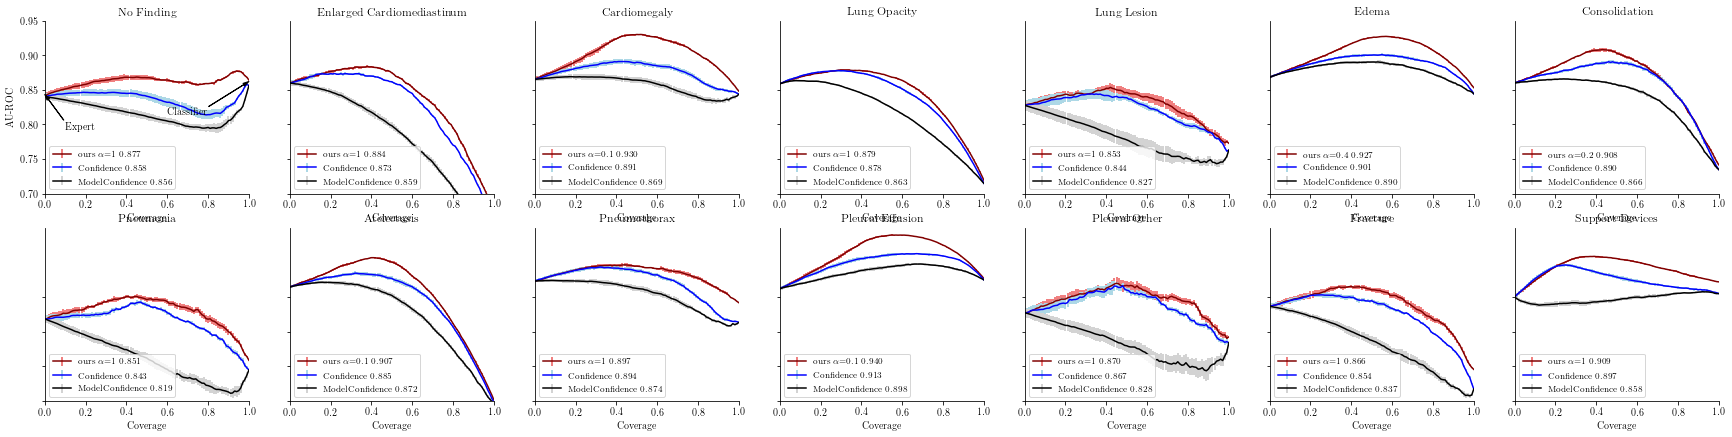

In [ ]:

import matplotlib.pyplot as plt


j = 0
for k in range(14):
    if k != 2 and k!= 5 and k != 6 and k != 8 and k!= 10:
        continue
    f = plt.subplot(1, 5, j+1)
    j += 1
    plt.title(class_names[k])
    #plt.plot(covs[k], aucs[k],label = f'ours alpha={alpha[k]}: max AUC {max(aucs[k]):.3f}')
    plt.errorbar(covs[k], [np.average([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ours $\\alpha$={alpha[k]} {max([np.average([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='maroon',ecolor='lightcoral', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'Confidence {max([np.average([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='blue',ecolor='lightblue', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ModelConfidence {max([np.average([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='black',ecolor='lightgray', elinewidth=2, capsize=0)
    #plt.plot(covs_confidence[k], aucs_confidence[k], label =' Confidence: max AUC %0.3f' % max(aucs_confidence[k]))

    plt.legend(loc = 'lower left',fontsize=9)
    plt.xlim([0, 1])
    plt.ylim([0.7, 0.95])
    #plt.plot([0.5, 0.5], [0, 1],'r--')
    if j == 1:
        #plt.text(covs[0][0] +0.03,aucs[k][0] - 0.005,'Expert', horizontalalignment='left', verticalalignment='top', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})
        #plt.plot(covs[0][0] ,aucs[k][0], marker='o', markersize=3)
        plt.annotate('Expert', xy=(covs[0][0], aucs[k][0]), xytext=(covs[0][0] +0.1, aucs[k][0] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        #plt.plot(covs[0][0] ,aucs[k][0], marker='o', markersize=7)
        plt.annotate('Classifier', xy=(covs[0][-1], aucs[k][-1]-0.002), xytext=(covs[0][-1] -0.4, aucs[k][-1] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        plt.ylabel('AU-ROC')
    else:
        plt.yticks(ticks= [0.7,0.75,0.8,0.85],labels=[])
    f.spines['right'].set_visible(False)
    f.spines['top'].set_visible(False)
    plt.xlabel('Coverage')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.savefig("auc_vs_cov_toyexpert7-1.pdf",dpi=1000)
plt.show()

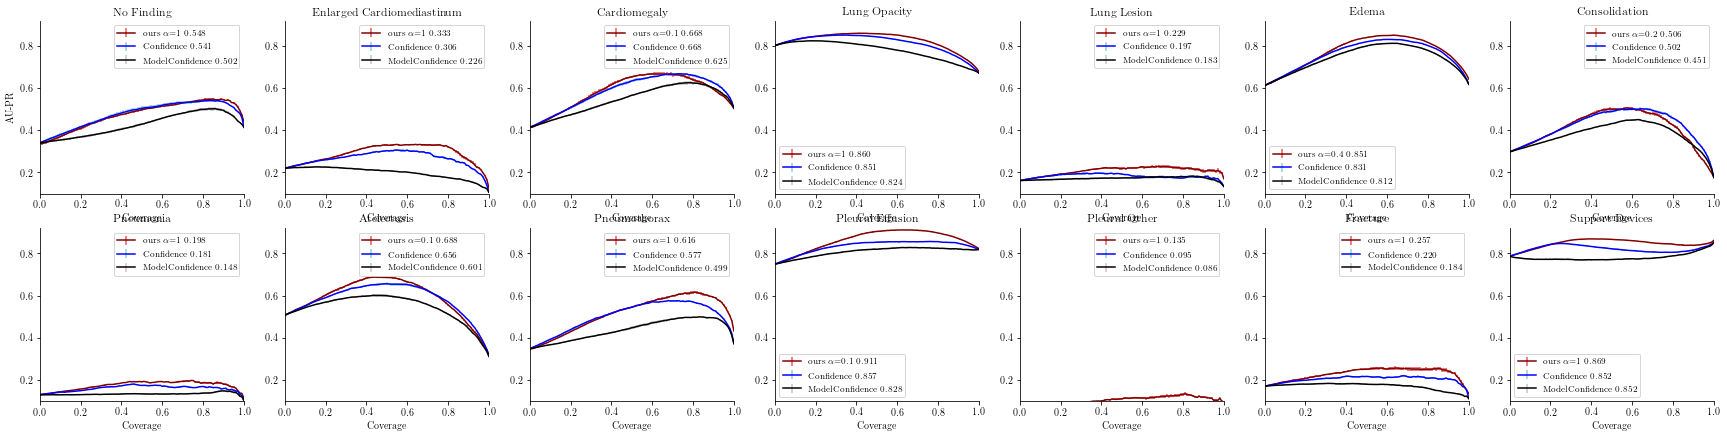

In [ ]:

import matplotlib.pyplot as plt
j = 0
for k in range(14):
    if k != 2 and k!= 5 and k != 6 and k != 8 and k!= 10:
        continue
    f = plt.subplot(1, 5, j+1)
    j += 1
    plt.title(class_names[k])
    plt.errorbar(covs[k], [np.average([aps_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aps_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ours $\\alpha$={alpha[k]} {max([np.average([aps_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='maroon',ecolor='lightcoral', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aps_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aps_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'Confidence {max([np.average([aps_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='blue',ecolor='lightblue', elinewidth=2, capsize=0)
    plt.errorbar(covs[k], [np.average([aps_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))] , yerr=[np.std([aps_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))], label=f'ModelConfidence {max([np.average([aps_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]):.3f}',color='black',ecolor='lightgray', elinewidth=2, capsize=0)

    plt.legend(fontsize=9,loc='best')
    plt.xlim([0, 1])
    #plt.ylim([0.2, 0.92])
    #plt.plot([0.5, 0.5], [0, 1],'r--')
    f.spines['right'].set_visible(False)
    f.spines['top'].set_visible(False)
    if j == 1:
        plt.ylim([0.4, 0.8])
        #plt.annotate('Expert', xy=(covs[0][0], aps[k][0]), xytext=(covs[0][0] +0.1, aps[k][0] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        #plt.annotate('Classifier', xy=(covs[0][-1], aps[k][-1]), xytext=(covs[0][-1] -0.4, aps[k][-1] -0.05),arrowprops=dict(facecolor='black', width=0.2,headwidth=3,headlength=6))
        plt.ylabel('AU-PR')
    elif j ==2:
        plt.ylim([0.5, 0.9])
    elif j == 3:
        plt.ylim([0.2, 0.6])

    elif j == 4:
        plt.ylim([0.3, 0.7])
    elif j == 5:
        plt.ylim([0.6, 1.0])
        #plt.yticks(ticks= [0.20,0.3,0.4,0.5,0.6,0.7,0.8,0.9],labels=[])
    plt.ylim([0.1, 0.92])
    plt.xlabel('Coverage')
plt.savefig("ap_vs_cov_toyexpert7-1.pdf",dpi=1000) #_trainsize-"+str(train_size)+"
plt.show()

In [ ]:
for k in range(14):
    #if k != 2 and k!= 5 and k != 6 and k != 8 and k!= 10:
    #    continue
    print("#############################")
    print(f'on task {class_names[k]}')
    defer = [np.average([aucs_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]
    conf = [np.average([aucs_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]
    confidence = [np.average([aucs_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]
    defer = np.asarray(defer[1:100])
    conf = np.asarray(conf[1:100])
    confidence = np.asarray(confidence[1:100])
    print(f'AUC difference between Defer and ModelConfidence is {np.average(defer-conf):.3f}$\\pm${np.std(defer-conf):.3f}')
    print(f'AUC difference between Defer and Confidence is {np.average(defer-confidence):.3f}$\\pm${np.std(defer-confidence):.3f}')

In [ ]:
for k in range(14):
    #if k != 2 and k!= 5 and k != 6 and k != 8 and k!= 10:
    #    continue
    print("#############################")
    print(f'on task {class_names[k]}')
    defer = [np.average([aps_defer_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]
    conf = [np.average([aps_conf_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]
    confidence = [np.average([aps_confidence_list[triall][k][i] for triall in range(max_trials)]) for i in range(len(aucs[k]))]
    defer = np.asarray(defer[1:100])
    conf = np.asarray(conf[1:100])
    confidence = np.asarray(confidence[1:100])
    print(f'AP difference between Defer and ModelConfidence is {np.average(defer-conf):.3f}$\\pm${np.std(defer-conf):.3f}')
    print(f'AP difference between Defer and Confidence is {np.average(defer-confidence):.3f}$\\pm${np.std(defer-confidence):.3f}')